# Chapter03 word2vec
이번 장에는 추론 기반 기법을 사용한다.  
추론 과정에서 신경망을 사용하고, 여기서 word2vec이 등장.  

## 3.1 추론 기반 기법과 신경망

### 3.1.1 통계 기반 기법의 문제점
어휘가 100만개면 100만*100만 의 행렬을 계산해야 한다. 여기에 SVD를 적용하는건 무리다.  
(SVD의 복잡도는 O(n**3))  
통계기반기법은 데이터를 한번에 처리한다(batch). 추론기반기법은 조금씩 쓴다(minibatch)  

### 3.1.2 추론 기반 기법 개요
추론: 주변 단어(맥락)이 주어졌을 때, 빈칸의 단어를 추측하는 작업.  
ex: "you [   ] goodbye and i say hello" 

### 3.1.3 신경망에서의 단어 처리
단어를 one hot vector로 변환. 
index가 단어 id와 같으면 1, 아니면 0.  
이런 방법으로 입력의 크기를 고정한다.  

In [1]:
import numpy as np

C = np.array([1, 0, 0, 0, 0, 0, 0]) #input
W = np.random.randn(7, 3)           #weight
h = np.matmul(C, W)                 #hidden node
print(h)

[ 0.47167304  0.96859856 -1.29090961]


C is one hot vector.  
thus, C*W means we extracted single row from W.

In [2]:
import sys
sys.path.append('..')
import numpy as np
from common.layers import MatMul

c = np.array([1, 0, 0, 0, 0, 0, 0])
W = np.random.randn(7,3)
layer = MatMul(W) #?
h = layer.forward(c)
print(h)

[ 0.56953879  0.03512242 -0.51395428]


## 3.2 simple word2vec
we are going to use CBOW(Continuous bag-of-words) for neural network

### 3.2.1 CBOW model's inference process
target word: blank words.  
context: words around target word  
we use multiple inputs. N words for context => N inputs  
hidden layer's input will be (h1 + h2)/N   
output layer's neuron are map of our words.  
W(in) is distributed expression of words

In [3]:
import sys
sys.path.append('..')
import numpy as np
from common.layers import MatMul

#sample context data
c0 = np.array([[1, 0, 0, 0, 0, 0, 0]])
c1 = np.array([[0, 0, 1, 0, 0, 0, 0]])

#initializing weights
W_in = np.random.randn(7,3)
W_out = np.random.randn(3, 7)

#계층 생성
in_layer0 = MatMul(W_in)
in_layer1 = MatMul(W_in)
out_layer = MatMul(W_out)

#순전파
h0 = in_layer0.forward(c0)
h1 = in_layer1.forward(c1)
h = 0.5 * (h0 + h1)
s = out_layer.forward(h)

print(s)

[[ 1.22177788e+00  1.04258115e-01  1.05141753e+00 -1.94352697e-03
  -1.96416889e+00  2.98756978e-01 -8.24743898e-01]]


### 3.2.2 CBOW's training
we use softmax and CEE to measure loss.  
(skip-gram is our model)

### 3.2.3 word2vec's weight and distributed expression
W_in has information of words.  (7 x 3)  
W_out also has information of words. in column (3 x 7)  
what do we use?  we could use both of them. simply get mean.  
we will use W_in. which is common

## 3.3 preparing train data

### 3.3.1 context and target

we want to predict "target" from our "context". we will use neural netowrk to train so.

In [9]:
import sys
sys.path.append('..')

import numpy as np
from common.util import preprocess

text = 'You say Goodbye and i say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
print(corpus)
#[0 1 2 3 4 1 5 6]

print(id_to_word)

[0 1 2 3 4 1 5 6]
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


we try to make function gets corpus, and spits out context(6,2) and target(6).

In [10]:
def create_contexts_target(corpus, window_size = 1):
    target = corpus[window_size:-window_size] # Q: ?
    contexts = []
    
    for idx in range(window_size, len(corpus) - window_size):
        cs = []
        for t in range(-window_size, window_size + 1):
            if t == 0:
                continue
            cs.append(corpus[idx + t])
        contexts.append(cs)
        
    return np.array(contexts), np.array(target)

In [11]:
contexts, target = create_contexts_target(corpus, window_size=1)
print(contexts)
print(target)

[[0 2]
 [1 3]
 [2 4]
 [3 1]
 [4 5]
 [1 6]]
[1 2 3 4 1 5]


### 3.3.2 convert into one-hot vector
easy peasy

In [12]:
import sys
sys.path.append('..')
from common.util import preprocess, create_contexts_target, convert_one_hot

text = 'You say goodbye and i say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

contexts, target = create_contexts_target(corpus, window_size=1)

vocab_size = len(word_to_id)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

## 3.4 CBOW model 

In [13]:
import sys
sys.path.append('..')
import numpy as np
from common.layers import MatMul, SoftmaxWithLoss

class SimpleCBOW:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size
        
        #init weights
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')
        
        #making layers
        self.in_layer0 = MatMul(W_in)
        self.in_layer1 = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer = SoftmaxWithLoss()
        
        #collect every weights and gradients in list
        layers = [self.in_layer0, self.in_layer1, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads
            
        # store distributed expression in instance variable
        self.word_vecs = W_in

In [1]:
def forward(self, context, target):
    h0 = self.in_layer0.forward(contexts[:, 0])
    h1 = self.in_layer1.forward(contexts[:, 1])
    h = (h0 + h1) * 0.5
    score = self.out_layer.forward(h)
    loss = self.loss_layer.forward(score, target)
    return loss

forward/backward are defined little differently in here. contexts are 3 dimension.

In [2]:
def backward(self, dout = 1):
    ds = self.loss_layer.backward(dout)
    da = self.out_layer.backward(ds)
    da *= 0.5
    self.in_layer1.backward(da)
    self.in_layer0.backward(da)
    
    return None

### 3.4.1 implementaion

| 에폭 1 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 2 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 3 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 4 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 5 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 6 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 7 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 8 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 9 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 10 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 11 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 12 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 13 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 14 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 15 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 16 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 17 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 18 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 19 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 20 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 21 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 22 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 23 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 24 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 25 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 26 |

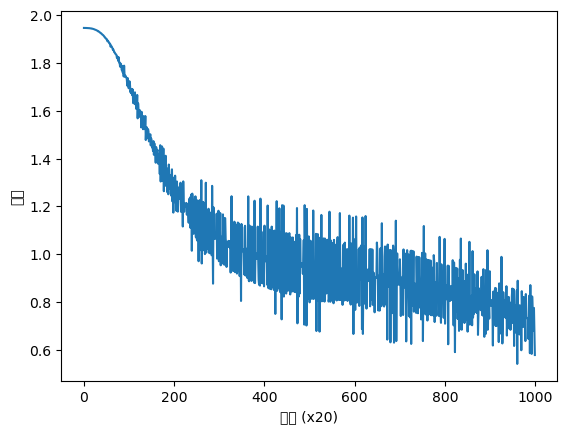

In [3]:
import sys
sys.path.append('..')
from common.trainer import Trainer
from common.optimizer import Adam
from simple_cbow import SimpleCBOW
from common.util import preprocess, create_contexts_target, convert_one_hot

window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

vocab_size = len(word_to_id)
contexts, target = create_contexts_target(corpus, window_size)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

model = SimpleCBOW(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()



In [4]:
word_vecs = model.word_vecs
for word_id, word in id_to_word.items():
    print(word, word_vecs[word_id])

you [-1.2291725 -1.1303886 -1.14125   -1.042314  -1.2660881]
say [1.1733716 1.1532665 1.183328  1.128262  1.114861 ]
goodbye [-0.67204857 -0.7994972  -0.7904725  -0.9283007  -0.6394847 ]
and [ 1.2355237   1.2822853   1.2085254   1.5111157  -0.65373063]
i [-0.6702517  -0.7860087  -0.78158426 -0.94073534 -0.65153146]
hello [-1.2271194 -1.1430984 -1.1416043 -1.0594689 -1.2631724]
. [ 0.5829158   0.43168056  0.7121009  -0.16463204  1.8613347 ]


we are now able to express word into dense vector.  
thie vectors has the 'meaning' of words

## 3.5 word2vec complementory

### 3.5.1 CBOW model and probability
P(A) : probability of A  
P(A * B) : simultaneous probability of A and B  
P(A | B) : posterior probability of A after B. probability of A given B.  

if corpus are w_1, w_2, ... w_t-1, w_t, w_t+1, ... ... w_T  
our CBOW model predicts probability of w_t given w_t-1 and w_t+1.  
P(w | w_t-1, w_t+1)  

Cross Entropy Error를 적용해보자.  
L = -Sum(t_k * log(y_k))인데, t_k는 label이다.  
L = -log(P(w_t | w_t-1, w_t+1))  
CBOW's loss function is simply put minus and log on posterior probability. (negative log likelyhood)  
this is loss function for only one sample data. if you expand to corpus, it becomes  
L - (1/T) * Sum(log(P(w_t | w_t-1, w_t+1)))  

### 3.5.2 skip-gram model
word2vec suggests two model. one is CBOW, and other one is skip-gram model.  
skip gram model is reversed version of CBOW.  
skip gram model predicts words around target from target.  
input layer is only single, and output matrices are multiple.  


skip-gram predicts: P(w_t-1, w_t+1 | w_t)  
P(w_t-1, w_t+1 | w_t) = P(w_t-1 | w_t) * P(w_t+1 | w_t)  
we can infer loss function of skip-gram model.  
for one sample data, loss function is:  
L = -log(P(w-,w+ | w))  
= -log(P(w-|w)P(w+|w))  
= -( log(P(w-|w)) + log(P(w+|w))  )

for whole corpus, loss function is:  
L = (-1/T)*SUM(log(P(w-|w)) + log(P(w+|w)))

which one is better?  
answer is skip-gram.  
CBOW is faster at learninng.  
but skip-gram is better at word represent

### 3.5.3 statistic vs inference
statistical method train one time.  
inference method train multiple time by training little batches from corpus.  

-suppose we need to re-train due to new vocabulary  
--statistical method needs to train everything again. SVD, co-matrix.    
--inference method can use our trained data so far.

-how about accuracy of word representation?
--statistical method: encodes similarities of words  
--inference method, especially skip-gram model: similarities, and more complex relationships between words. (king - man + woman = queen)  
but in quantified test, both methods are almost equally accurate.  

more importantly, they are both related.  
skip-gram model and every model that uses negative sampling is co-matrix with specific matrix decomposition!  

we now have GloVe method that uses both method. 

## 3.6 conclusion
we learned word2vec. we can explain and make CBOW model.  
CBOW is basically simple two layer model.  
it learned small corpus. but it can be improved.  
on next chapter, we will improve CBOW model